In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random

import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch
import torch.optim as optim
from torch.utils.data import Dataset
from PIL import Image
import torch.nn as nn

import warnings
warnings.filterwarnings("ignore")

import glob
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
masks = glob.glob("/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/*/*_mask.png")
images = [mask_images.replace("_mask", "") for mask_images in masks]
series = list(zip(images, masks))

dataset = pd.DataFrame(series, columns=['image_path', 'mask_path'])

In [3]:
class CustomImageDataset(Dataset):

    def __init__(self, dataframe, image_transform=None):
        self.data = dataframe
        self.image_transform = image_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data.iloc[idx]['image_path']

        image = Image.open(image_path).convert('L') 

        if self.image_transform:
            image = self.image_transform(image)

        return image

# Define transformations with selected augmentation techniques and normalization for grayscale
image_size = 128
    
train_transforms = transforms.Compose([
    transforms.Resize([image_size, image_size]),
    transforms.ToTensor(),
])

# Create datasets
train_dataset = CustomImageDataset(dataset, train_transforms)

# Create DataLoaders
batch_size = 8
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [4]:
for batch in dataloader:
    inputs = batch
    
    # Print the shapes
    print("Input shape:", inputs.shape)
    break

Input shape: torch.Size([8, 1, 128, 128])


In [5]:
class LinearAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(128*128, 64*64),
            nn.Tanh(),
            nn.Linear(64*64, 32*32),
            nn.Tanh(),
            nn.Linear(32*32, 16*16),
        )
        self.decoder = nn.Sequential(
            nn.Linear(16*16, 32*32),
            nn.Tanh(),
            nn.Linear(32*32, 64*64),
            nn.Tanh(),
            nn.Linear(64*64, 128*128),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [6]:
lae = LinearAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(lae.parameters(), lr=1e-4, weight_decay=1e-5)

In [7]:
num_epochs = 100
for epoch in range(1, num_epochs + 1):
    for image in dataloader:
        image = image.view(-1, 128*128).to(device)
        outputs = lae(image)
        loss = criterion(outputs, image)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/100], Loss: 0.0186
Epoch [2/100], Loss: 0.0127
Epoch [3/100], Loss: 0.0210
Epoch [4/100], Loss: 0.0142
Epoch [5/100], Loss: 0.0109
Epoch [6/100], Loss: 0.0142
Epoch [7/100], Loss: 0.0139
Epoch [8/100], Loss: 0.0124
Epoch [9/100], Loss: 0.0120
Epoch [10/100], Loss: 0.0082
Epoch [11/100], Loss: 0.0107
Epoch [12/100], Loss: 0.0103
Epoch [13/100], Loss: 0.0111
Epoch [14/100], Loss: 0.0090
Epoch [15/100], Loss: 0.0097
Epoch [16/100], Loss: 0.0135
Epoch [17/100], Loss: 0.0105
Epoch [18/100], Loss: 0.0107
Epoch [19/100], Loss: 0.0063
Epoch [20/100], Loss: 0.0118
Epoch [21/100], Loss: 0.0117
Epoch [22/100], Loss: 0.0084
Epoch [23/100], Loss: 0.0080
Epoch [24/100], Loss: 0.0125
Epoch [25/100], Loss: 0.0106
Epoch [26/100], Loss: 0.0119
Epoch [27/100], Loss: 0.0129
Epoch [28/100], Loss: 0.0122
Epoch [29/100], Loss: 0.0093
Epoch [30/100], Loss: 0.0087
Epoch [31/100], Loss: 0.0100
Epoch [32/100], Loss: 0.0079
Epoch [33/100], Loss: 0.0094
Epoch [34/100], Loss: 0.0122
Epoch [35/100], Loss: 0

In [8]:
def plot_images(original_images, reconstructed_images, num_images=5, img_shape=(128, 128)):
    num_images = min(num_images, len(original_images))
    fig, axes = plt.subplots(2, num_images, figsize=(num_images * 3, 6))

    for i in range(num_images):
        axes[0, i].imshow(np.reshape(original_images[i], img_shape), cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title('Original')

        axes[1, i].imshow(np.reshape(reconstructed_images[i], img_shape), cmap='gray')
        axes[1, i].axis('off')
        axes[1, i].set_title('Reconstructed')

    plt.show()

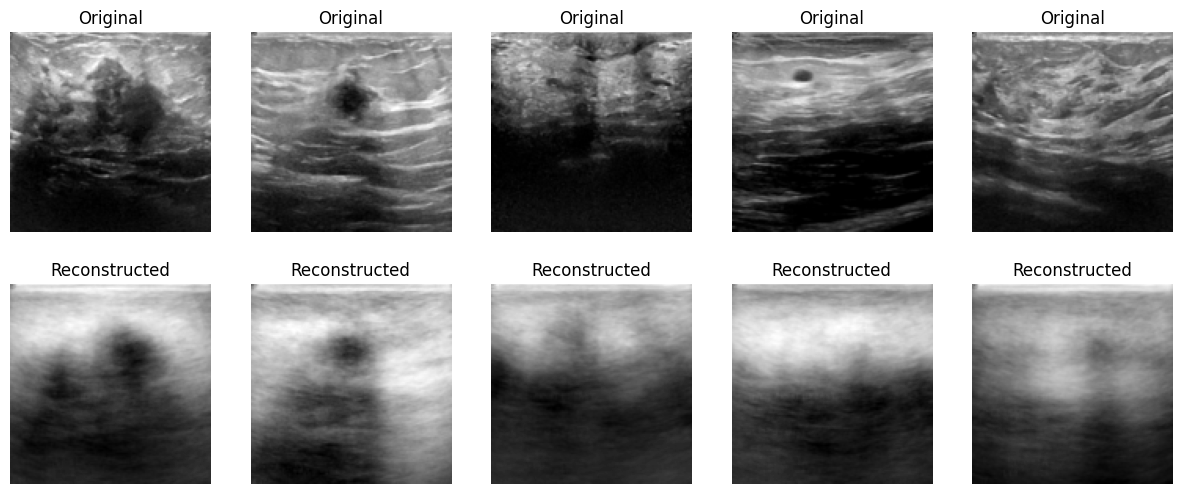

In [9]:
lae.eval()

for images in dataloader:
    images = images.to(device)
    images = images.view(images.size(0), -1)
    reconstructed_images = lae(images)
    images_np = images.cpu().numpy()
    reconstructed_np = reconstructed_images.cpu().detach().numpy()
    
    plot_images(images_np, reconstructed_np)
    break

In [10]:
import torch.nn as nn

class CNNAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.Tanh(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.Tanh(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.Tanh(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.Tanh(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.Tanh(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.Tanh(),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoder = self.encoder(x)
        decoder = self.decoder(encoder)
        
        return decoder


In [11]:
cae = CNNAutoEncoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(cae.parameters(), lr=1e-4, weight_decay=1e-5)

In [12]:
num_epochs = 100
for epoch in range(1, num_epochs + 1):
    for image in dataloader:
        image = image.to(device)
        outputs = cae(image)
        loss = criterion(outputs, image)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/100], Loss: 0.0637
Epoch [2/100], Loss: 0.0517
Epoch [3/100], Loss: 0.0279
Epoch [4/100], Loss: 0.0318
Epoch [5/100], Loss: 0.0274
Epoch [6/100], Loss: 0.0224
Epoch [7/100], Loss: 0.0184
Epoch [8/100], Loss: 0.0117
Epoch [9/100], Loss: 0.0253
Epoch [10/100], Loss: 0.0107
Epoch [11/100], Loss: 0.0278
Epoch [12/100], Loss: 0.0130
Epoch [13/100], Loss: 0.0087
Epoch [14/100], Loss: 0.0107
Epoch [15/100], Loss: 0.0131
Epoch [16/100], Loss: 0.0084
Epoch [17/100], Loss: 0.0095
Epoch [18/100], Loss: 0.0114
Epoch [19/100], Loss: 0.0081
Epoch [20/100], Loss: 0.0082
Epoch [21/100], Loss: 0.0069
Epoch [22/100], Loss: 0.0071
Epoch [23/100], Loss: 0.0058
Epoch [24/100], Loss: 0.0054
Epoch [25/100], Loss: 0.0091
Epoch [26/100], Loss: 0.0066
Epoch [27/100], Loss: 0.0035
Epoch [28/100], Loss: 0.0044
Epoch [29/100], Loss: 0.0047
Epoch [30/100], Loss: 0.0068
Epoch [31/100], Loss: 0.0044
Epoch [32/100], Loss: 0.0070
Epoch [33/100], Loss: 0.0034
Epoch [34/100], Loss: 0.0038
Epoch [35/100], Loss: 0

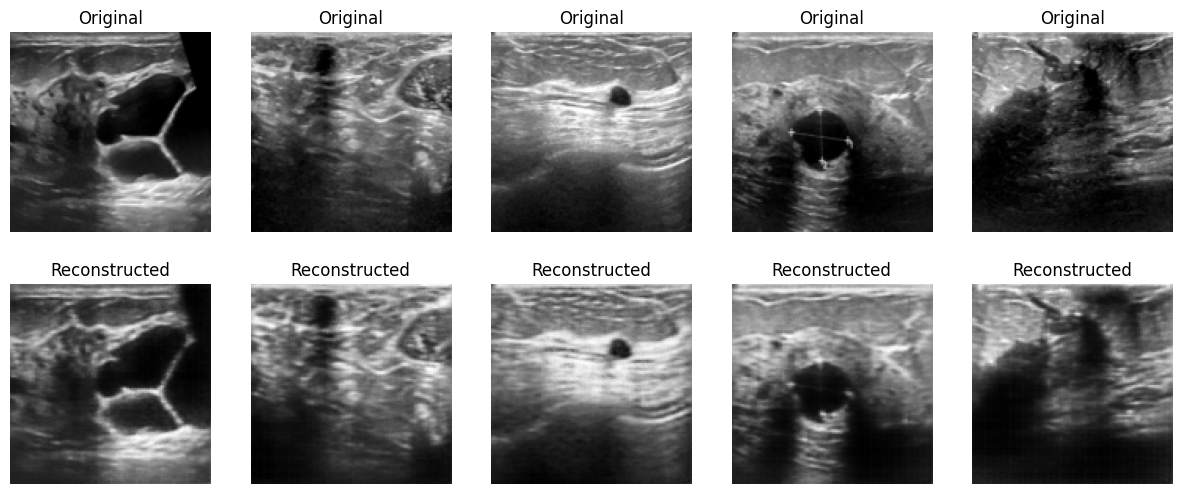

In [13]:
cae.eval()

for images in dataloader:
    images = images.to(device)
    reconstructed_images = cae(images)
    images_np = images.cpu().numpy()
    reconstructed_np = reconstructed_images.cpu().detach().numpy()
    
    plot_images(images_np, reconstructed_np)
    break